## Objetivo: realizar a análise exploratória dos dados

### Importações

In [35]:
# Importando bibliotecas

import pandas as pd
import numpy as np

import re
import nltk
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"]=(14, 6)


### Carregando base de dados tratados:

In [36]:
df = pd.read_csv("base_fake_news_trat.csv")
df.head()

,ID,txt_limpo,txt_tratado,txt_stemizado,Categoria,data_proc,Fake
0,1,Kátia Abreu diz que vai colocar sua expulsão e...,katia abreu colocar expulsao moldura reclamar ...,kat abr coloc expulsa mold reclam sen kat abr ...,politica,2017-11-30 00:00:00,1
1,10,"Dr. Ray peita Bolsonaro, chama-o de ""conservad...",ray peita bolsonaro chama conservador fake ent...,ray peit bolsonar cham conserv fak entrev dani...,politica,2017-11-24 00:00:00,1
2,100,Reinaldo Azevedo desmascarado pela Polícia Fed...,reinaldo azevedo desmascarado policia federal ...,reinald azeved desmascar polic feder ferrenh c...,politica,2017-05-23 00:00:00,1
3,1000,Relatório assustador do BNDES mostra dinheiro ...,relatorio assustador bndes mostra dinheiro pub...,relatori assust bnd mostr dinh publ brasil jor...,politica,2017-07-24 00:00:00,1
4,1001,"Radialista americano fala sobre o PT: ""Eles ve...",radialista americano fala vendem ilusao povo b...,radial americ fal vend ilusa pov brasil pens d...,politica,2017-07-25 00:00:00,1


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             7200 non-null   int64 
 1   txt_limpo      7200 non-null   object
 2   txt_tratado    7200 non-null   object
 3   txt_stemizado  7200 non-null   object
 4   Categoria      7200 non-null   object
 5   data_proc      7200 non-null   object
 6   Fake           7200 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 393.9+ KB


### EDA:

In [38]:
# Avaliando valores duplicados: Existe uma notícia duplicada

df.duplicated().sum(), df["txt_limpo"].duplicated().sum()

(0, 1)

In [39]:
# A notícia duplicada é uma verdadeira, de onde se originou duas fakes

txt = df.loc[df["txt_limpo"].duplicated(), "txt_limpo"].values[0]
ids = df.loc[df["txt_limpo"]==txt, "ID"].values
df.loc[df["ID"].isin(ids)]

,ID,txt_limpo,txt_tratado,txt_stemizado,Categoria,data_proc,Fake
3169,61,Inimigos de Reinaldo Azevedo agora estão junto...,inimigos reinaldo azevedo juntos jovem pan rad...,inimig reinald azeved junt jov pan radi jov pa...,tv_celebridades,2017-06-27 00:00:00,1
3257,69,Temer é o líder da mais perigosa organização c...,temer lider perigosa organizacao criminosa bra...,tem lid perig organizaca crimin brasil palavr ...,politica,2017-06-17 00:00:00,1
6769,61,Suplicy participará de programa de Doria na we...,suplicy participara programa doria web quintao...,suplicy particip program dor web quinta vere e...,tv_celebridades,2017-09-08 00:00:00,0
6857,69,Suplicy participará de programa de Doria na we...,suplicy participara programa doria web quintao...,suplicy particip program dor web quinta vere e...,politica,2017-07-10 00:00:00,0


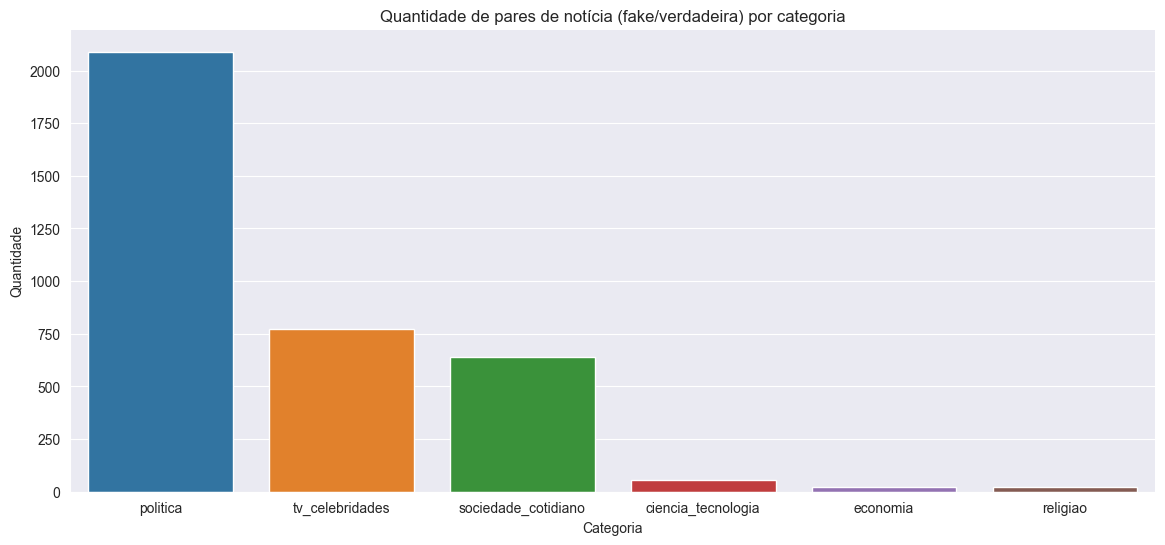

In [40]:
counts = df["Categoria"].value_counts()/2

plt.figure()
sns.barplot(x=counts.index, y=counts.values)
plt.title("Quantidade de pares de notícia (fake/verdadeira) por categoria")
plt.xlabel("Categoria")
plt.ylabel("Quantidade")
sns.despine()

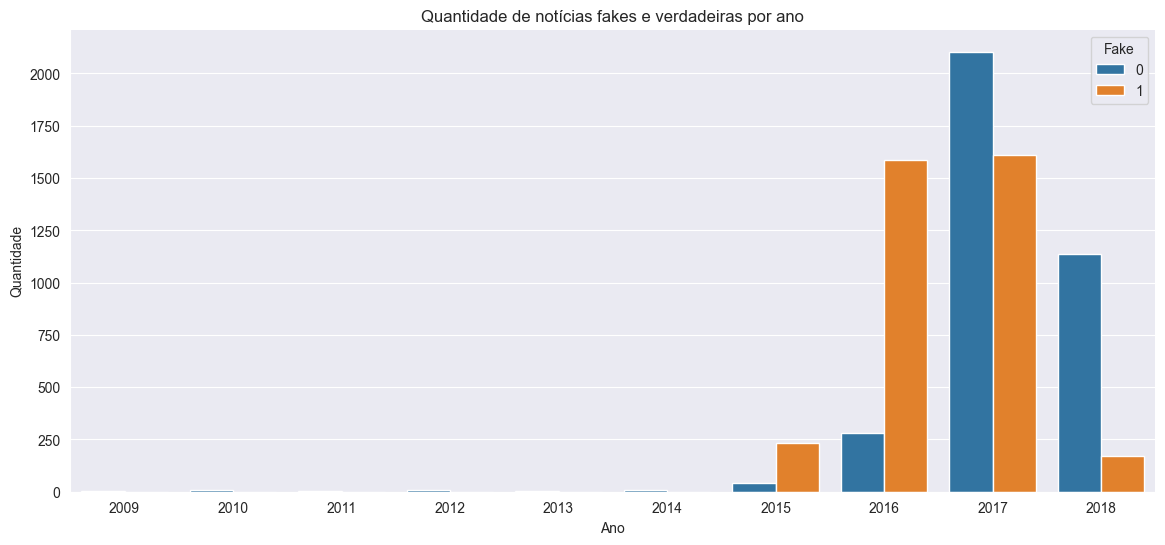

In [41]:
df["data_proc"] = pd.to_datetime(df["data_proc"])
df["Ano"] = df["data_proc"].dt.year
counts = df["Ano"].value_counts()

plt.figure()
sns.countplot(x=df["Ano"], hue=df["Fake"])
plt.title("Quantidade de notícias fakes e verdadeiras por ano")
plt.xlabel("Ano")
plt.ylabel("Quantidade")
sns.despine()

In [42]:
df["Mes"] = df["data_proc"].dt.month
df.query("Ano==2018")["Mes"].max()

12

In [43]:
df["QDO_PUBLICOU"] = None
for id in df["ID"].unique():
  date_false = df.loc[(df["ID"]==id)&(df["Fake"]==1), "data_proc"].values[0]
  date_true = df.loc[(df["ID"]==id)&(df["Fake"]==0), "data_proc"].values[0]

  if date_false > date_true:
    df.loc[(df["ID"]==id)&(df["Fake"]==1), "QDO_PUBLICOU"] = "Depois"
    df.loc[(df["ID"]==id)&(df["Fake"]==0), "QDO_PUBLICOU"] = "Antes"
  else:
    df.loc[(df["ID"]==id)&(df["Fake"]==1), "QDO_PUBLICOU"] = "Antes"
    df.loc[(df["ID"]==id)&(df["Fake"]==0), "QDO_PUBLICOU"] = "Depois"

In [44]:
df_cross = pd.crosstab(df["Ano"], [df["Fake"], df["QDO_PUBLICOU"]])
df_cross

Fake             0            1       
QDO_PUBLICOU Antes Depois Antes Depois
Ano                                   
2009             3      0     0      0
2010             6      0     0      0
2011             5      0     0      0
2012             9      0     1      0
2013             5      0     0      0
2014            10      0     0      0
2015            33      7   233      2
2016           146    133  1502     84
2017           414   1690  1160    449
2018            27   1112    46    123

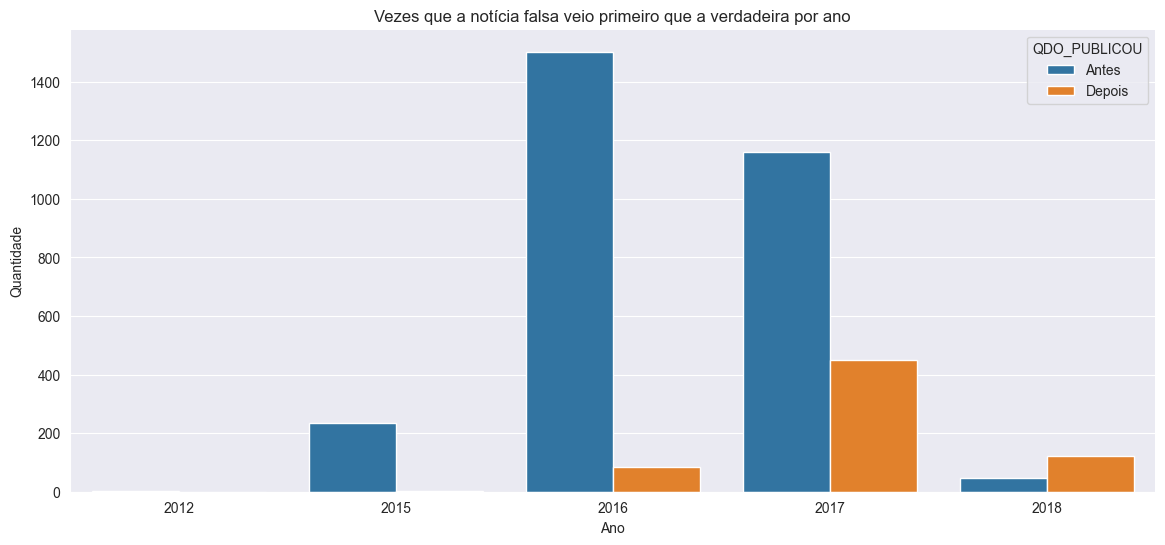

In [45]:
sns.countplot(data=df.loc[df["Fake"]==1],
              x="Ano",
              hue="QDO_PUBLICOU")
plt.title("Vezes que a notícia falsa veio primeiro que a verdadeira por ano")
plt.xlabel("Ano")
plt.ylabel("Quantidade")
sns.despine()

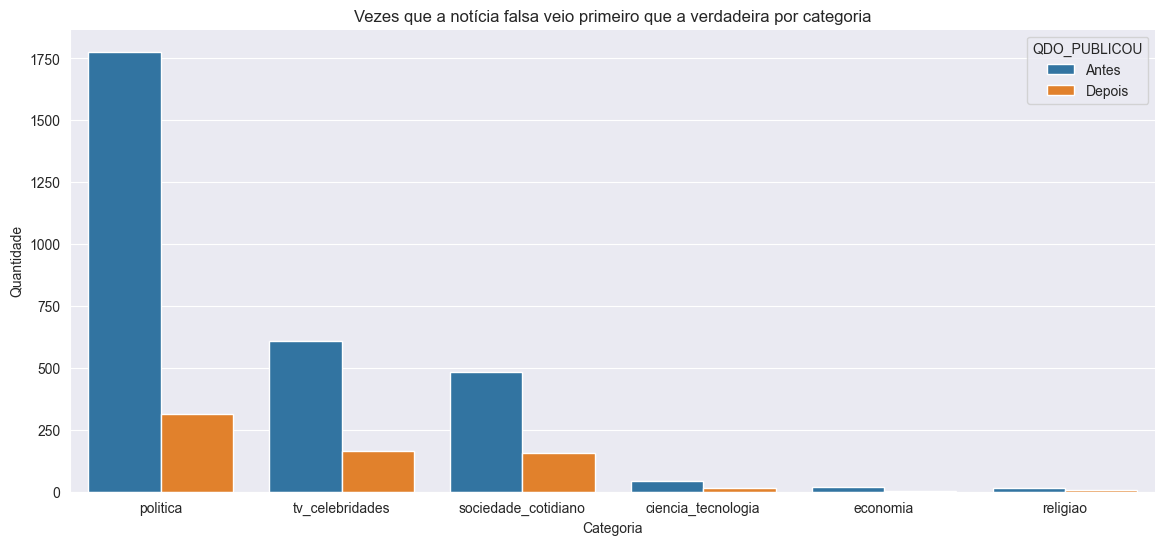

In [46]:
sns.countplot(data=df.loc[df["Fake"]==1],
              x="Categoria",
              hue="QDO_PUBLICOU")
plt.title("Vezes que a notícia falsa veio primeiro que a verdadeira por categoria")
plt.xlabel("Categoria")
plt.ylabel("Quantidade")
sns.despine()


In [47]:
df_cross = pd.crosstab(df["Ano"], df["Categoria"])
df_cross.sort_values(by="Ano", ascending=False)

Categoria,ciencia_tecnologia,economia,politica,religiao,sociedade_cotidiano,tv_celebridades
Ano,,,,,,
2018,25,4,709,11,219,340
2017,72,23,2008,30,796,784
2016,10,10,1280,2,224,339
2015,3,6,169,0,25,72
2014,1,0,5,1,1,2
2013,0,0,2,0,2,1
2012,0,1,4,0,3,2
2011,1,0,2,0,1,1
2010,0,0,1,0,2,3


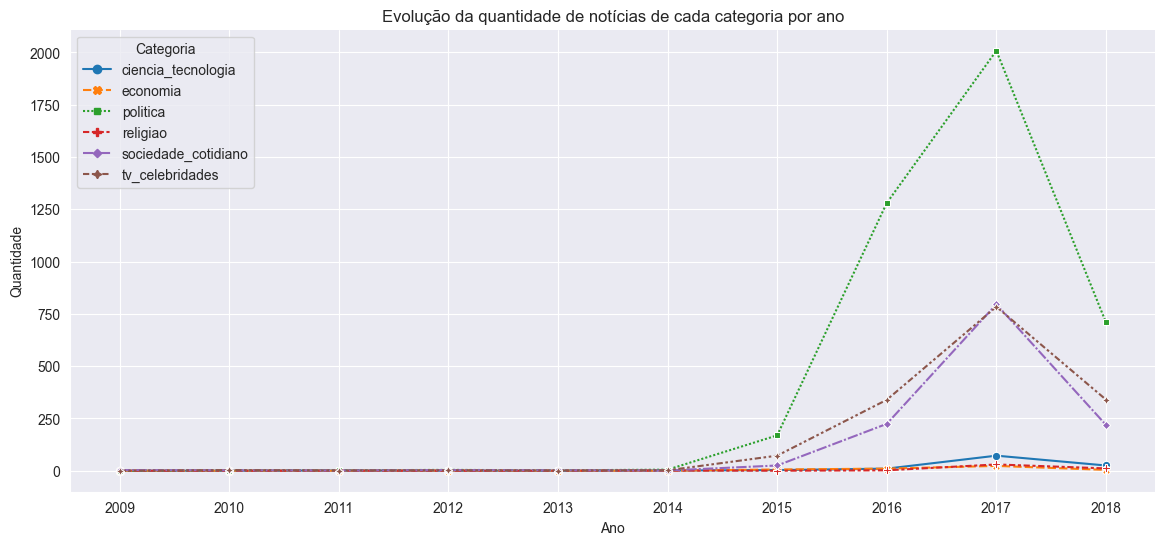

In [48]:
sns.lineplot(data=df_cross,
             markers=True)
plt.title("Evolução da quantidade de notícias de cada categoria por ano");
plt.ylabel("Quantidade");
plt.xticks(list(range(2009, 2019)))
sns.despine()

In [49]:
df["TAM_MEDIO_TKNS"] = df["txt_tratado"].apply(lambda t: np.mean(list(map(len, t.split()))))
df["NUM_TKNS"] = df["txt_tratado"].apply(lambda t: len(t.split()))
df["NUM_LETRAS_MAIUSC"] = df["txt_limpo"].apply(lambda t: len(re.findall(r'[A-Z]', t)))
df["NUM_PONTUACOES"] = df["txt_limpo"].apply(lambda t: len(re.findall(r'[^\w\s]', t)))

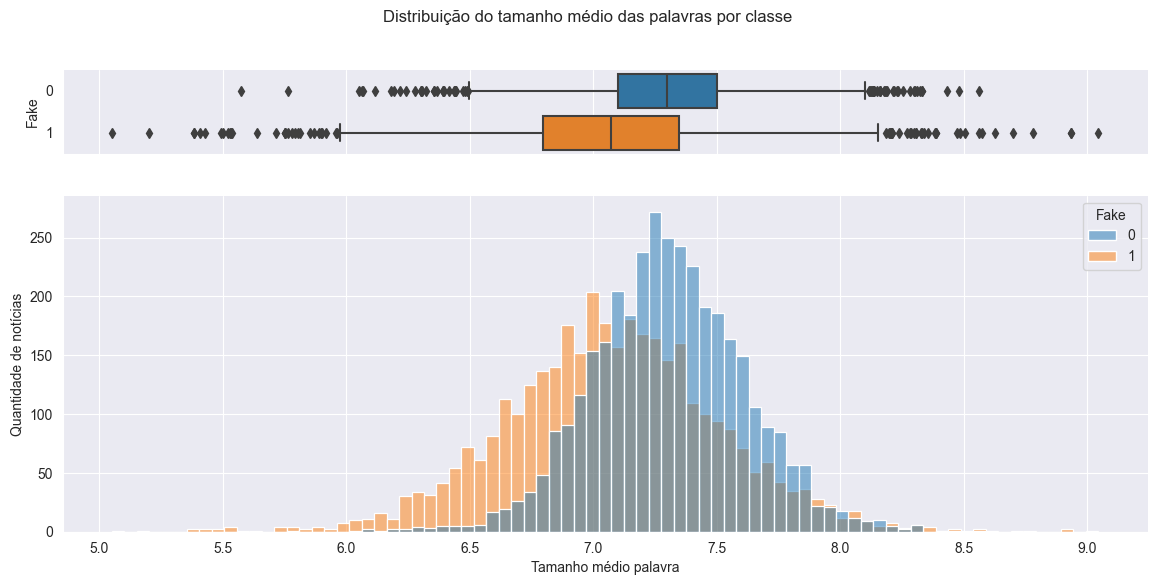

In [50]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)})

sns.boxplot(x=df["TAM_MEDIO_TKNS"],y=df["Fake"].astype("category"), ax=ax_box)
sns.histplot(data=df, x="TAM_MEDIO_TKNS", hue="Fake", ax=ax_hist)

ax_box.set(xlabel="")
ax_hist.set(xlabel="Tamanho médio palavra", ylabel="Quantidade de notícias")
f.suptitle("Distribuição do tamanho médio das palavras por classe");
sns.despine()

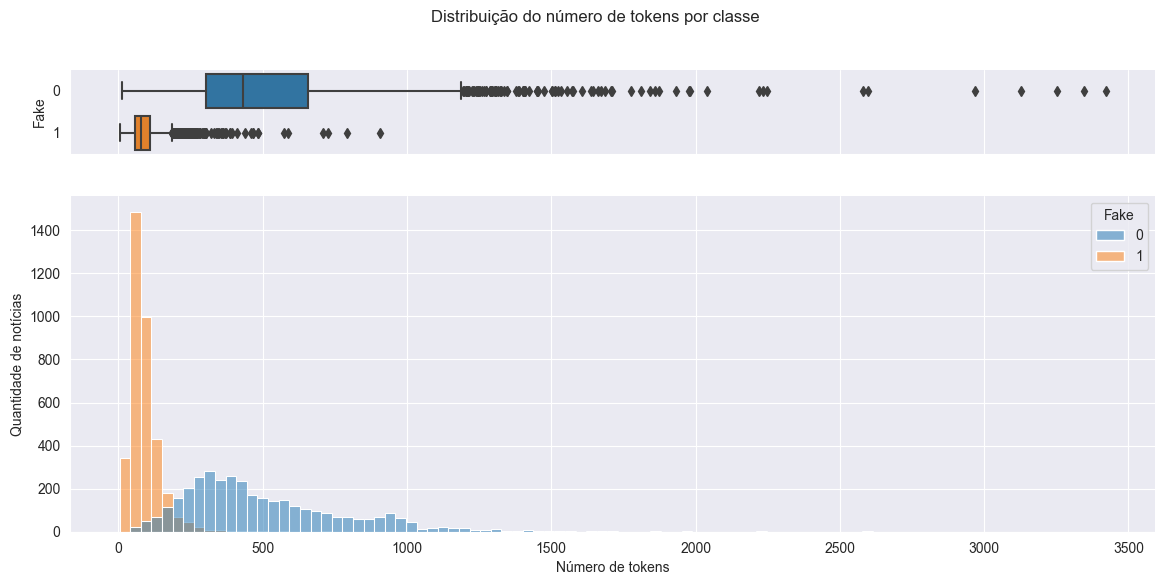

In [51]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)})

sns.boxplot(x=df["NUM_TKNS"],y=df["Fake"].astype("category"), ax=ax_box)
sns.histplot(data=df, x="NUM_TKNS", hue="Fake", ax=ax_hist)

ax_box.set(xlabel="")
ax_hist.set(xlabel="Número de tokens", ylabel="Quantidade de notícias")
f.suptitle("Distribuição do número de tokens por classe");
sns.despine()

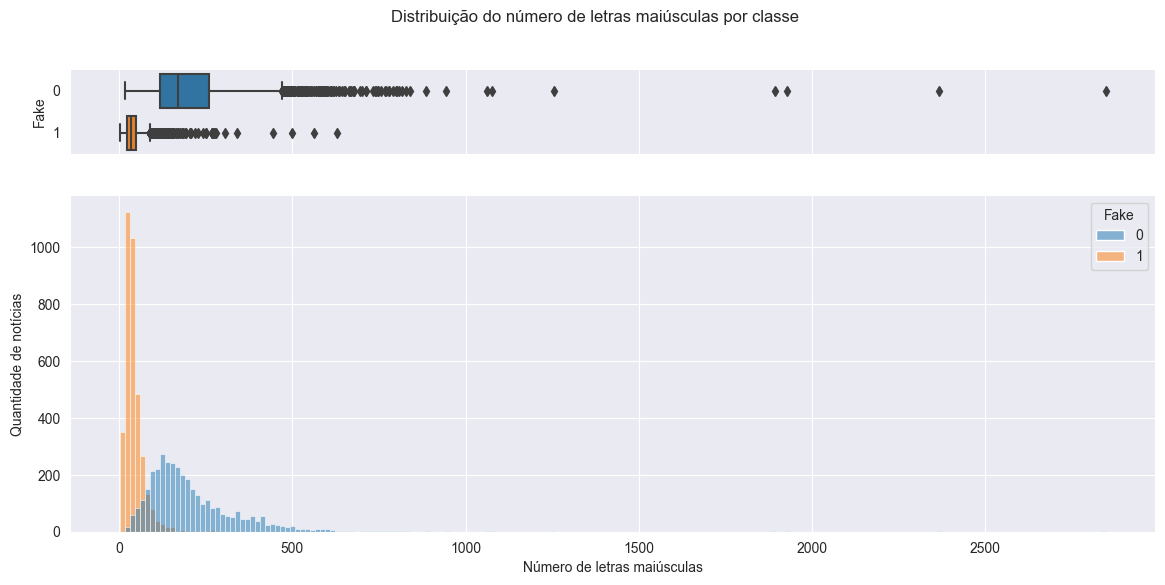

In [52]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)})

sns.boxplot(x=df["NUM_LETRAS_MAIUSC"],y=df["Fake"].astype("category"), ax=ax_box)
sns.histplot(data=df, x="NUM_LETRAS_MAIUSC", hue="Fake", ax=ax_hist)

ax_box.set(xlabel="")
ax_hist.set(xlabel="Número de letras maiúsculas", ylabel="Quantidade de notícias")
f.suptitle("Distribuição do número de letras maiúsculas por classe");
sns.despine()

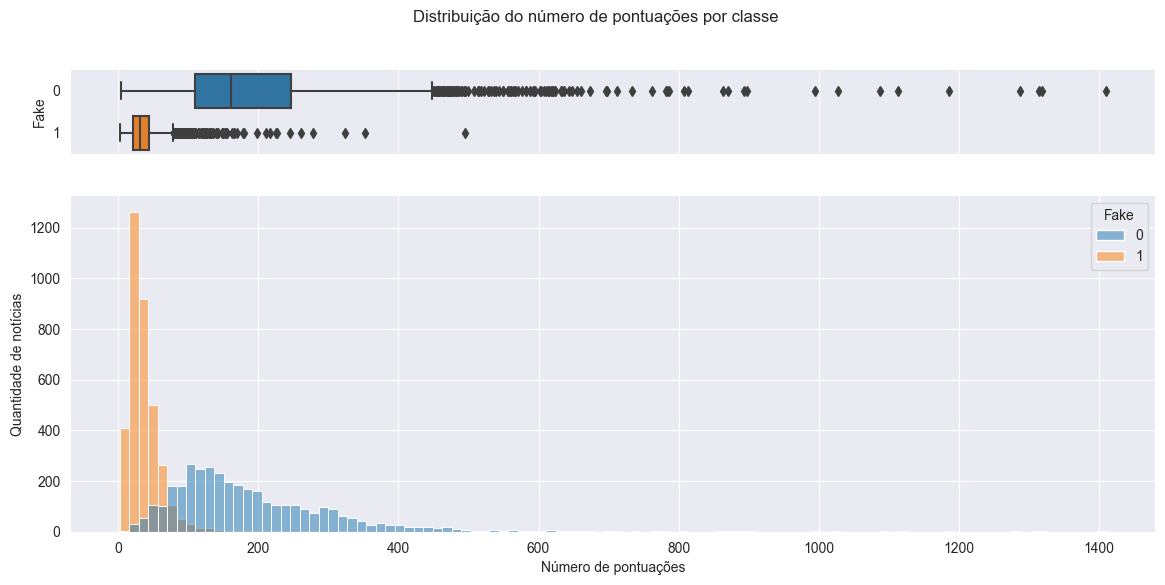

In [53]:
px.histogram(data_frame=df,
             x="NUM_PONTUACOES",
             color="Fake",
             marginal='box',
             title="Distribuição do número de pontuações gramaticais por classe")

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)})

sns.boxplot(x=df["NUM_PONTUACOES"],y=df["Fake"].astype("category"), ax=ax_box)
sns.histplot(data=df, x="NUM_PONTUACOES", hue="Fake", ax=ax_hist)

ax_box.set(xlabel="")
ax_hist.set(xlabel="Número de pontuações", ylabel="Quantidade de notícias")
f.suptitle("Distribuição do número de pontuações por classe");
sns.despine()

Text(0.5, 1.0, '20 unigramas mais frequentes nas notícias verdadeiras')

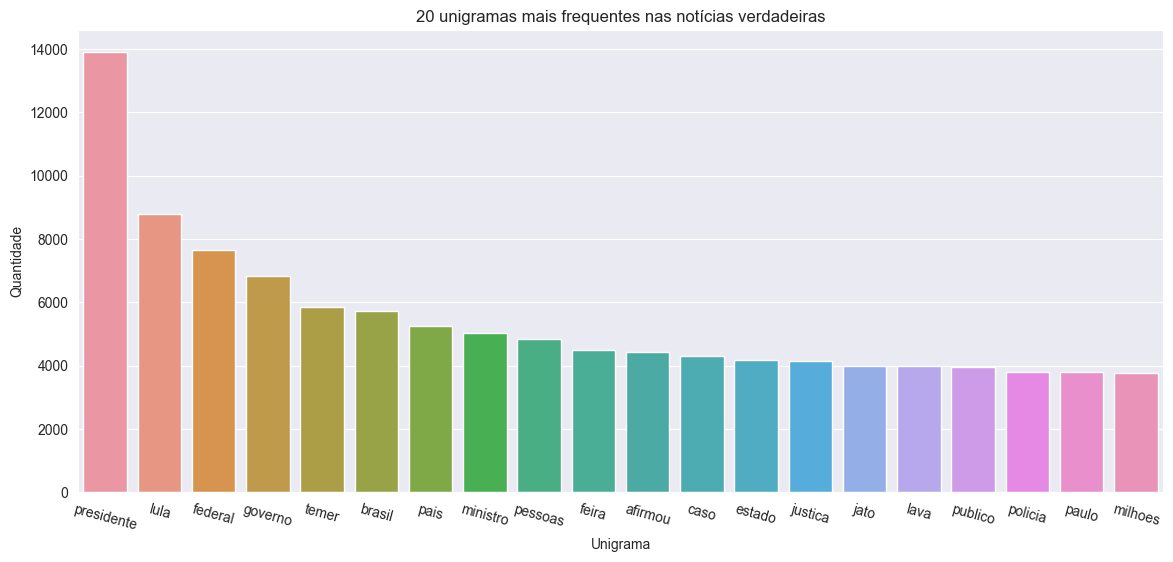

In [54]:
freqs = nltk.FreqDist(nltk.word_tokenize(" ".join(df.loc[df["Fake"]==0, "txt_tratado"].values)))

sns.barplot(x=[tkn for tkn, _ in freqs.most_common(20)],
            y=[count for _, count in freqs.most_common(20)])
plt.ylabel("Quantidade")
plt.xlabel("Unigrama")
plt.xticks(rotation = -15)
plt.title("20 unigramas mais frequentes nas notícias verdadeiras")

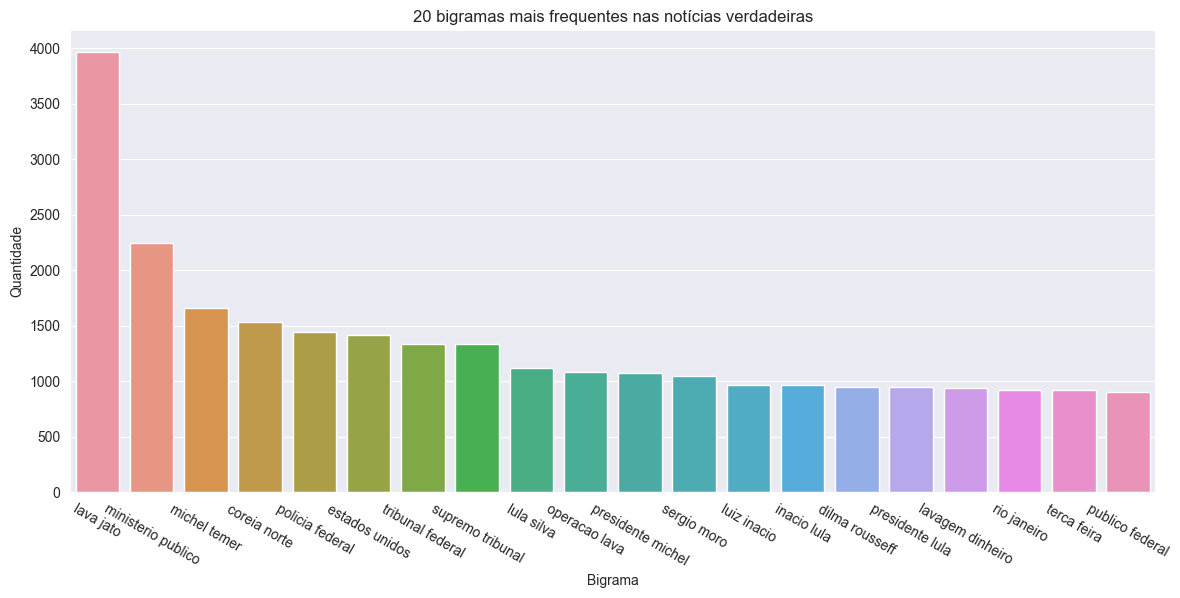

In [55]:
freqs = nltk.FreqDist(nltk.bigrams(nltk.word_tokenize(" ".join(df.loc[df["Fake"]==0, "txt_tratado"].values))))

sns.barplot(x=[" ".join(tkns) for tkns, _ in freqs.most_common(20)],
            y=[count for _, count in freqs.most_common(20)])
plt.ylabel("Quantidade")
plt.xlabel("Bigrama")
plt.xticks(rotation = -30)
plt.title("20 bigramas mais frequentes nas notícias verdadeiras");

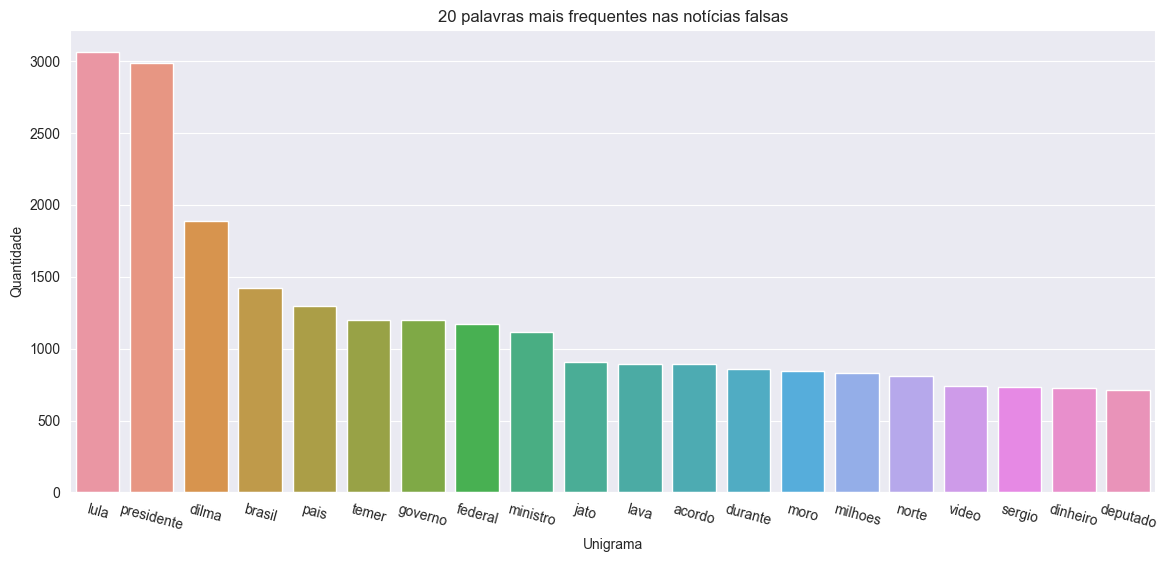

In [56]:
freqs = nltk.FreqDist(nltk.word_tokenize(" ".join(df.loc[df["Fake"]==1, "txt_tratado"].values)))

sns.barplot(x=[tkn for tkn, _ in freqs.most_common(20)],
            y=[count for _, count in freqs.most_common(20)])
plt.ylabel("Quantidade")
plt.xlabel("Unigrama")
plt.xticks(rotation = -15)
plt.title("20 palavras mais frequentes nas notícias falsas");

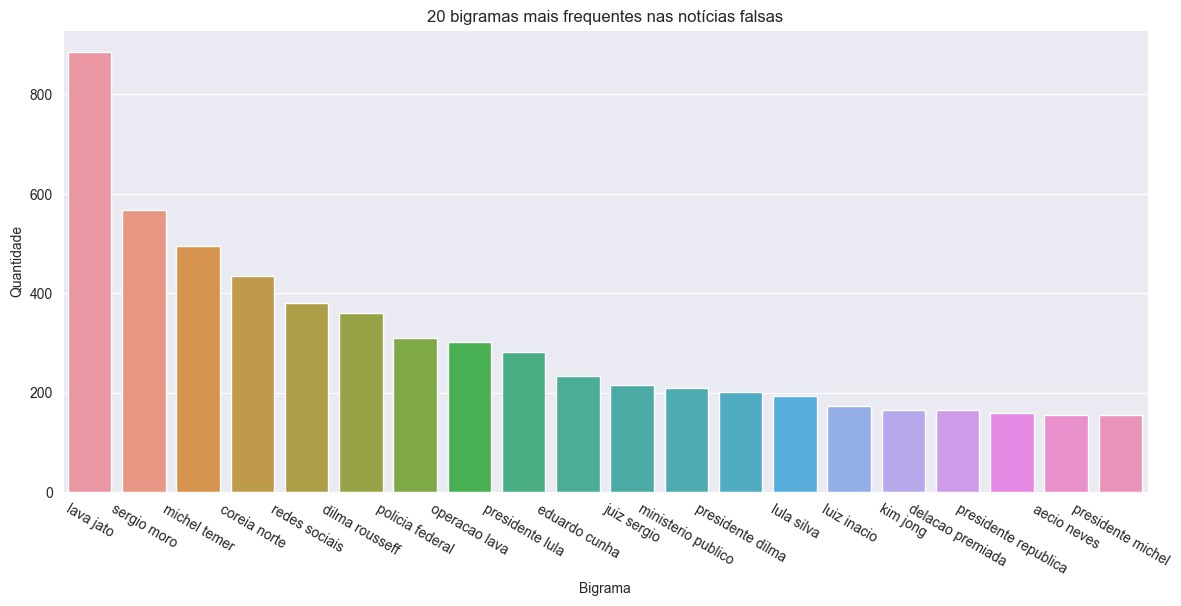

In [57]:
freqs = nltk.FreqDist(nltk.bigrams(nltk.word_tokenize(" ".join(df.loc[df["Fake"]==1, "txt_tratado"].values))))

sns.barplot(x=[" ".join(tkns) for tkns, _ in freqs.most_common(20)],
            y=[count for _, count in freqs.most_common(20)])
plt.ylabel("Quantidade")
plt.xlabel("Bigrama")
plt.xticks(rotation = -30)
plt.title("20 bigramas mais frequentes nas notícias falsas");

In [58]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000, sublinear_tf=True)
tfidf.fit(df["txt_tratado"])

df_tfidf = pd.DataFrame(tfidf.transform(df["txt_tratado"]).toarray(), columns=tfidf.get_feature_names_out())
df_tfidf.head()

,_____________,___________________,____________________,abaixo,abaixo integra,abandonado,abandonar,abandono,abandonou,abastecer,...,zeze perrella,zika,zona,zona leste,zona norte,zona oeste,zona rural,zona sul,zonas,zuckerberg
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.133763,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.037829,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(4180, 10000)
(1544, 10000)
(1276, 10000)
(112, 10000)
(44, 10000)
(44, 10000)


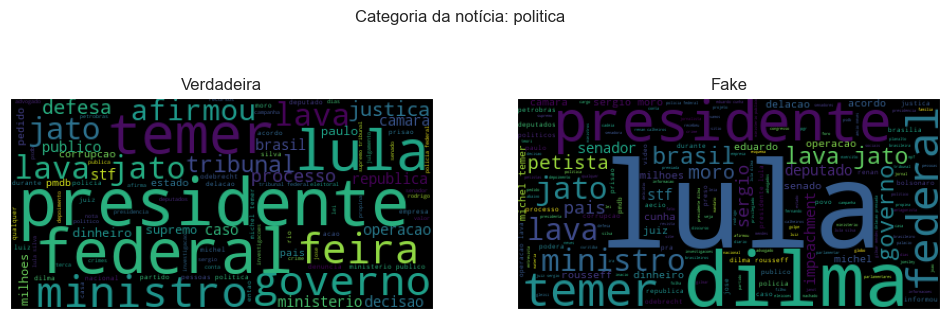

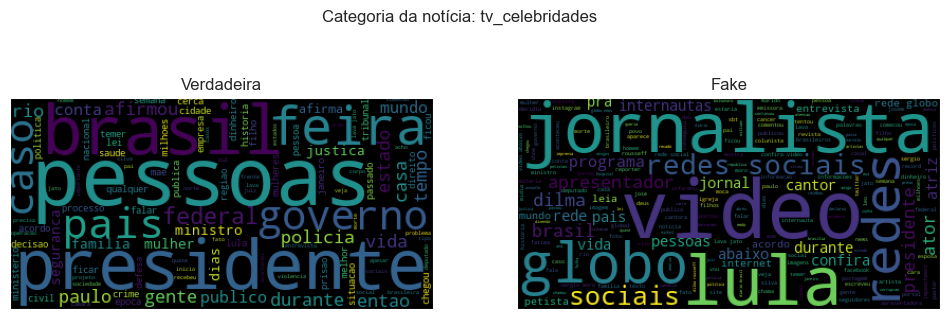

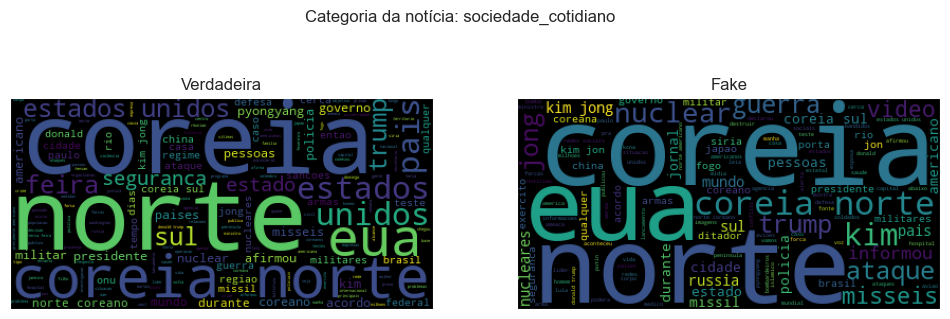

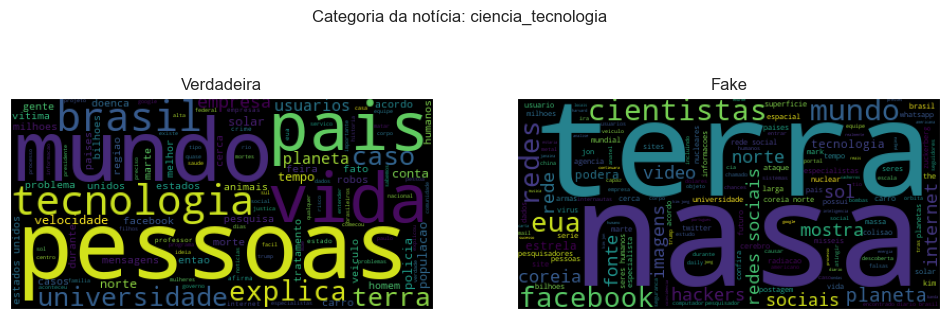

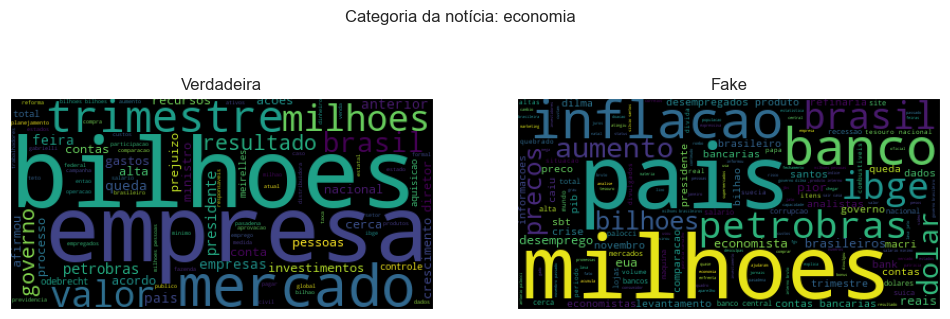

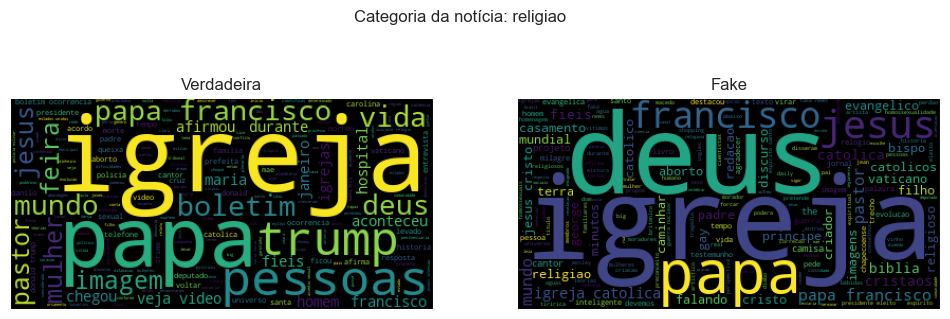

In [59]:
for cat in df["Categoria"].unique():

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  sub_df = df_tfidf.loc[df["Categoria"]==cat]

  print(sub_df.shape)

  y = df.loc[df["Categoria"]==cat, "Fake"]

  wc0 = WordCloud().generate_from_frequencies(sub_df.loc[y==0].mean())
  wc1 = WordCloud().generate_from_frequencies(sub_df.loc[y==1].mean())

  axes[0].imshow(wc0)
  axes[0].set_title("Verdadeira")
  axes[0].set_yticks([])
  axes[0].set_xticks([])

  axes[1].imshow(wc1)
  axes[1].set_title("Fake")
  axes[1].set_yticks([])
  axes[1].set_xticks([])

  fig.suptitle(f"Categoria da notícia: {cat}")
  fig.show()


In [60]:
df.loc[(df["txt_tratado"].str.contains("terra")) & (df["Categoria"]=='ciencia_tecnologia')].values[0]

array([1341,
       'As armas SECRETAS de Kim descobertas por satélites: 84 túneis e 6 mil bases subterrâneas. .  "A ameaça nuclear é real" disse Pense. Imagens captadas por satélites mostram áreas rurais da Coréia do Norte abrigando instalações nucleares secretas de Kim Jon-un, incluindo bases de testes subterrâneas. O Dr. James Hoare advertiu que existe uma ameaça escondida e que o presidente dos EUA deve realmente se preocupar. Hoare, que é um acadêmico, historiador e ex-diplomata residente em Pyongyang, afirmou que é praticamente impossível prever se as ameaças são reais: "Você pode visualizar o que está na superfície e ter suspeitas sobre alguns lugares, mas o grande poderio da Coreia está nas instalações subterrâneas" disse. Alguns desertores do exército de Kim ajudaram os EUA a mapear algumas das instalações subterrâneas do país. O exército americano calcula que exista de 6 a 8 mil bases subterrâneas. Além disso, 84 túneis secretos foram mapeados na fronteira com o Sul, alguns g